In [1]:
import os
import time
import torch
import datetime

import torch.nn as nn
from torch.autograd import Variable
from torchvision.utils import save_image

from sagan_models import Generator, Discriminator
from utils import *

In [2]:
from parameter import *
from trainer import Trainer
from data_loader import Data_Loader
from torch.backends import cudnn
from utils import make_folder
import torch_fidelity

In [3]:
config = get_parameters()

In [4]:
config.batch_size=64
config.imsize=64
config.train=False
config.pretrained_model=996975
config.dataset="celeb"
config.version="sagan_celeb"
config.adv_loss='hinge'

In [5]:
# data_loader = Data_Loader(config.train, config.dataset, config.image_path, config.imsize,
#                          config.batch_size, shuf=config.train)

In [6]:
# data_iter=iter(data_loader.loader())
# for i in data_iter:
#     print(len(i))
#     print(i[0].shape)
#     break

In [7]:
# trainer = Trainer(data_loader.loader(), config)

In [8]:
# trainer.G

In [9]:
# from torchsummary import summary
# summary(trainer.G,(128,1))
# summary(trainer.D,(3,64,64))

In [5]:
class Tester(object):
    def __init__(self, config):
        # exact model and loss
        self.model = config.model
        self.adv_loss = config.adv_loss

        # Model hyper-parameters
        self.imsize = config.imsize
        self.g_num = config.g_num
        self.z_dim = config.z_dim
        self.g_conv_dim = config.g_conv_dim
        self.d_conv_dim = config.d_conv_dim
        self.parallel = config.parallel

        self.lambda_gp = config.lambda_gp
        self.total_step = config.total_step
        self.d_iters = config.d_iters
        self.batch_size = config.batch_size
        self.num_workers = config.num_workers
        self.g_lr = config.g_lr
        self.d_lr = config.d_lr
        self.lr_decay = config.lr_decay
        self.beta1 = config.beta1
        self.beta2 = config.beta2
        self.pretrained_model = config.pretrained_model

        self.dataset = config.dataset
        self.use_tensorboard = config.use_tensorboard
        self.image_path = config.image_path
        self.log_path = config.log_path
        self.model_save_path = config.model_save_path
        self.sample_path = config.sample_path
        self.log_step = config.log_step
        self.sample_step = config.sample_step
        self.model_save_step = config.model_save_step
        self.version = config.version

        # Path
        self.log_path = os.path.join(config.log_path, self.version)
        self.sample_path = os.path.join(config.sample_path, self.version)
        self.model_save_path = os.path.join(config.model_save_path, self.version)

        self.build_model()

        if self.use_tensorboard:
            self.build_tensorboard()

        # Start with trained model
        if self.pretrained_model:
            self.load_pretrained_model()
    
    def test(self):
        make_folder('./','generated_dataset{}_sparse'.format(self.pretrained_model))
        # 一共可得到1000*64=64000张照片
        for i in range(1000):
            # 一定要用randn,不可用rand！ 前者为正态分布，后者为均匀分布
            rand_z=tensor2var(torch.randn(self.batch_size, self.z_dim))
            fake_images,_,_=self.G(rand_z)
            for j in range(self.batch_size):
                save_image(denorm(fake_images[j]),'./generated_dataset'+str(self.pretrained_model)+'_sparse/{}_fake.png'.format(i*64+j + 1))
            # save_image(denorm(fake_images),'./generated_dataset/tot.png')

    def build_model(self):

        self.G = Generator(self.batch_size,self.imsize, self.z_dim, self.g_conv_dim).cuda()
        self.D = Discriminator(self.batch_size,self.imsize, self.d_conv_dim).cuda()
        if self.parallel:
            self.G = nn.DataParallel(self.G)
            self.D = nn.DataParallel(self.D)

        # Loss and optimizer
        # self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.g_lr, [self.beta1, self.beta2])
        self.g_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.G.parameters()), self.g_lr, [self.beta1, self.beta2])
        self.d_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.D.parameters()), self.d_lr, [self.beta1, self.beta2])

        self.c_loss = torch.nn.CrossEntropyLoss()

    def load_pretrained_model(self):
        self.G.load_state_dict(torch.load(os.path.join(
            self.model_save_path, '{}_G.pth'.format(self.pretrained_model))))
        self.D.load_state_dict(torch.load(os.path.join(
            self.model_save_path, '{}_D.pth'.format(self.pretrained_model))))
        print('loaded trained models (step: {})..!'.format(self.pretrained_model))

In [11]:
# !python -m pytorch_fid ./generated_dataset996975 ./data/CelebA/img_align_celeba/img_align_celeba --device cuda:0

In [12]:
# FID=torch.zeros(10)
# FID[0]=98.36766537081229
# FID[5]=99.15743182237708
# FID[9]=106.43966820133824
# print(FID)

In [6]:
ISCs=[]
FIDs=[]
configs=[]
pretrained_models=[10000 * i for i in range(1,11)]
for i in range(10):
    config.pretrained_model=pretrained_models[i]
    
    if not os.path.exists('./generated_dataset{}_sparse'.format(pretrained_models[i])):
        tester=Tester(config)
        tester.test()
    
    metrics_dict = torch_fidelity.calculate_metrics(
        input1='./generated_dataset{}_sparse'.format(pretrained_models[i]),
        input2='./data/transformed_images',
        cuda=True,
        fid=True,
        isc=True
    )
    
    print(metrics_dict)
    FIDs.append(metrics_dict['frechet_inception_distance'])
    ISCs.append(metrics_dict['inception_score_mean'])

loaded trained models (step: 10000)..!


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "./generated_dataset10000_sparse" with extensions png,jpg,jpeg
Found 64000 samples
c:\Users\Owner\conda\envs\torch_cuda\Lib\site-packages\torch_fidelity\datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                              
Extracting features from input2
Looking for samples non-recursivelty in "./data/transformed_images" with extensions png,jpg,jpeg
Found 202599 samples, some are lossy-compressed - this may affect metrics
Proce

{'inception_score_mean': 2.346818449457983, 'inception_score_std': 0.020707458055406157, 'frechet_inception_distance': 80.66293601902424}
loaded trained models (step: 20000)..!


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "./generated_dataset20000_sparse" with extensions png,jpg,jpeg
Found 64000 samples
Processing samples                                                              
Extracting features from input2
Looking for samples non-recursivelty in "./data/transformed_images" with extensions png,jpg,jpeg
Found 202599 samples, some are lossy-compressed - this may affect metrics
Processing samples                                                                
Inception Score: 2.08153673507718 ± 0.012882226311895874
Frechet Inception Distance: 51.890380092103925


{'inception_score_mean': 2.08153673507718, 'inception_score_std': 0.012882226311895874, 'frechet_inception_distance': 51.890380092103925}
loaded trained models (step: 30000)..!


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "./generated_dataset30000_sparse" with extensions png,jpg,jpeg
Found 64000 samples
Processing samples                                                              
Extracting features from input2
Looking for samples non-recursivelty in "./data/transformed_images" with extensions png,jpg,jpeg
Found 202599 samples, some are lossy-compressed - this may affect metrics
Processing samples                                                                
Inception Score: 2.018938661601477 ± 0.011125236950383935
Frechet Inception Distance: 39.893302215831454


{'inception_score_mean': 2.018938661601477, 'inception_score_std': 0.011125236950383935, 'frechet_inception_distance': 39.893302215831454}
loaded trained models (step: 40000)..!


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "./generated_dataset40000_sparse" with extensions png,jpg,jpeg
Found 64000 samples
Processing samples                                                              
Extracting features from input2
Looking for samples non-recursivelty in "./data/transformed_images" with extensions png,jpg,jpeg
Found 202599 samples, some are lossy-compressed - this may affect metrics
Processing samples                                                                
Inception Score: 1.9867179575693246 ± 0.017804249754037448
Frechet Inception Distance: 34.42065234347021


{'inception_score_mean': 1.9867179575693246, 'inception_score_std': 0.017804249754037448, 'frechet_inception_distance': 34.42065234347021}
loaded trained models (step: 50000)..!


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "./generated_dataset50000_sparse" with extensions png,jpg,jpeg
Found 64000 samples
Processing samples                                                              
Extracting features from input2
Looking for samples non-recursivelty in "./data/transformed_images" with extensions png,jpg,jpeg
Found 202599 samples, some are lossy-compressed - this may affect metrics
Processing samples                                                                
Inception Score: 1.9811475864652794 ± 0.010365634594933691
Frechet Inception Distance: 31.263293444564283


{'inception_score_mean': 1.9811475864652794, 'inception_score_std': 0.010365634594933691, 'frechet_inception_distance': 31.263293444564283}
loaded trained models (step: 60000)..!


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "./generated_dataset60000_sparse" with extensions png,jpg,jpeg
Found 64000 samples
Processing samples                                                              
Extracting features from input2
Looking for samples non-recursivelty in "./data/transformed_images" with extensions png,jpg,jpeg
Found 202599 samples, some are lossy-compressed - this may affect metrics
Processing samples                                                                
Inception Score: 2.0738476562297663 ± 0.011796895740965393
Frechet Inception Distance: 32.059229783138704


{'inception_score_mean': 2.0738476562297663, 'inception_score_std': 0.011796895740965393, 'frechet_inception_distance': 32.059229783138704}
loaded trained models (step: 70000)..!


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "./generated_dataset70000_sparse" with extensions png,jpg,jpeg
Found 64000 samples
Processing samples                                                              
Extracting features from input2
Looking for samples non-recursivelty in "./data/transformed_images" with extensions png,jpg,jpeg
Found 202599 samples, some are lossy-compressed - this may affect metrics
Processing samples                                                                
Inception Score: 1.9835838232076697 ± 0.017871105454544515
Frechet Inception Distance: 31.700851651081877


{'inception_score_mean': 1.9835838232076697, 'inception_score_std': 0.017871105454544515, 'frechet_inception_distance': 31.700851651081877}
loaded trained models (step: 80000)..!


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "./generated_dataset80000_sparse" with extensions png,jpg,jpeg
Found 64000 samples
Processing samples                                                              
Extracting features from input2
Looking for samples non-recursivelty in "./data/transformed_images" with extensions png,jpg,jpeg
Found 202599 samples, some are lossy-compressed - this may affect metrics
Processing samples                                                                
Inception Score: 2.1031379913189125 ± 0.00979567991810139
Frechet Inception Distance: 34.83856808487272


{'inception_score_mean': 2.1031379913189125, 'inception_score_std': 0.00979567991810139, 'frechet_inception_distance': 34.83856808487272}
loaded trained models (step: 90000)..!


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "./generated_dataset90000_sparse" with extensions png,jpg,jpeg
Found 64000 samples
Processing samples                                                              
Extracting features from input2
Looking for samples non-recursivelty in "./data/transformed_images" with extensions png,jpg,jpeg
Found 202599 samples, some are lossy-compressed - this may affect metrics
Processing samples                                                                
Inception Score: 2.0092935522482875 ± 0.018285644329472578
Frechet Inception Distance: 31.445116310420104


{'inception_score_mean': 2.0092935522482875, 'inception_score_std': 0.018285644329472578, 'frechet_inception_distance': 31.445116310420104}
loaded trained models (step: 100000)..!


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "./generated_dataset100000_sparse" with extensions png,jpg,jpeg
Found 64000 samples
Processing samples                                                              
Extracting features from input2
Looking for samples non-recursivelty in "./data/transformed_images" with extensions png,jpg,jpeg
Found 202599 samples, some are lossy-compressed - this may affect metrics
Processing samples                                                                
Inception Score: 2.0013012100089034 ± 0.0110537917454323
Frechet Inception Distance: 30.934487302153173


{'inception_score_mean': 2.0013012100089034, 'inception_score_std': 0.0110537917454323, 'frechet_inception_distance': 30.934487302153173}


In [7]:
FIDs

[80.66293601902424,
 51.890380092103925,
 39.893302215831454,
 34.42065234347021,
 31.263293444564283,
 32.059229783138704,
 31.700851651081877,
 34.83856808487272,
 31.445116310420104,
 30.934487302153173]

In [8]:
ISCs

[2.346818449457983,
 2.08153673507718,
 2.018938661601477,
 1.9867179575693246,
 1.9811475864652794,
 2.0738476562297663,
 1.9835838232076697,
 2.1031379913189125,
 2.0092935522482875,
 2.0013012100089034]

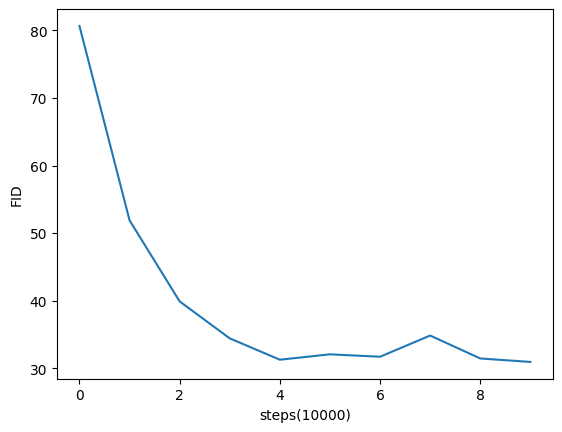

In [9]:
from matplotlib import pyplot as plt

plt.plot(FIDs)
plt.xlabel('steps(10000)')
plt.ylabel('FID')

# 显示图表
plt.show()